# Ценовой оптимизатор для маркетплейса (Mercari)

**Baseline-решение для динамического ценообразования**

Этот ноутбук содержит полный pipeline для решения задачи прогнозирования цен на маркетплейсе Mercari:

1. **Загрузка и очистка данных** (5 баллов)
2. **Анализ данных** (7 баллов) 
3. **Моделирование**: 3 простых модели + 1 усложнённая (8 баллов)
4. **Оценка качества** и анализ результатов (5 баллов)

---

**Датасет**: Mercari Price Suggestion Challenge  
**Задача**: Предсказание цены товара на основе его характеристик  
**Метрики**: RMSE, MAE, R²

## 1. Загрузка и очистка данных (5 баллов)

В этом разделе мы:
- Загружаем датасет Mercari
- Проводим первичный анализ структуры данных
- Очищаем данные от пропусков и аномалий
- Подготавливаем данные для дальнейшего анализа


In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Настройка стиля графиков
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("Библиотеки успешно импортированы!")


Библиотеки успешно импортированы!


In [2]:
# Загрузка данных
try:
    df = pd.read_csv('data/train.tsv', sep='\t')
    print("✅ Данные успешно загружены!")
    print(f"📊 Размер датасета: {df.shape[0]:,} строк, {df.shape[1]} столбцов")
except FileNotFoundError:
    print("❌ Файл data/train.tsv не найден!")
    print("Пожалуйста, скачайте датасет с Kaggle и поместите в папку data/")
    
# Первый взгляд на данные
print("\n🔍 Первые 5 строк:")
df.head()


✅ Данные успешно загружены!
📊 Размер датасета: 1,482,535 строк, 8 столбцов

🔍 Первые 5 строк:


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [3]:
# Информация о структуре данных
print("📋 Информация о данных:")
print(df.info())

print("\n📈 Статистическое описание:")
df.describe()


📋 Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482529 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None

📈 Статистическое описание:


,train_id,item_condition_id,price,shipping
count,1.482535e+06,1.482535e+06,1.482535e+06,1.482535e+06
mean,7.412670e+05,1.907380e+00,2.673752e+01,4.472744e-01
std,4.279711e+05,9.031586e-01,3.858607e+01,4.972124e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,3.706335e+05,1.000000e+00,1.000000e+01,0.000000e+00
50%,7.412670e+05,2.000000e+00,1.700000e+01,0.000000e+00
75%,1.111900e+06,3.000000e+00,2.900000e+01,1.000000e+00
max,1.482534e+06,5.000000e+00,2.009000e+03,1.000000e+00


🔍 Анализ пропущенных значений:
                  Пропуски (кол-во)  Пропуски (%)
category_name                  6327      0.426769
brand_name                   632682     42.675687
item_description                  6      0.000405


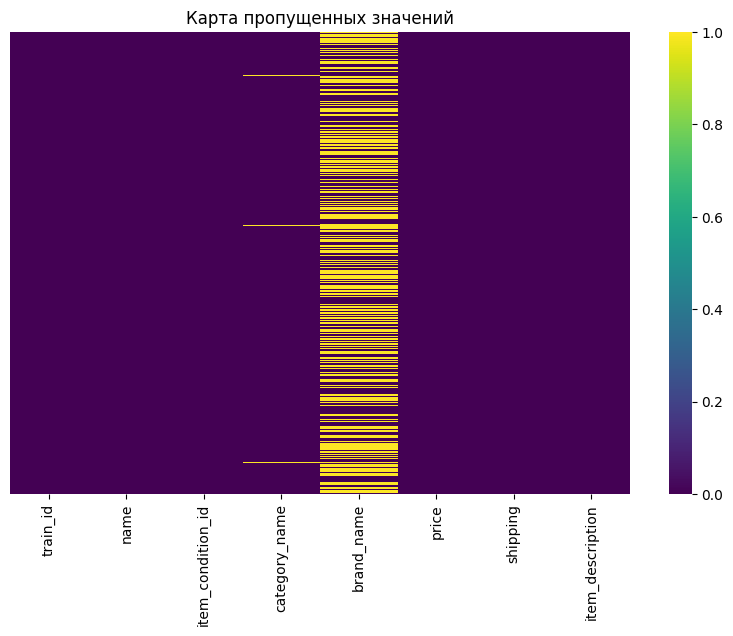

In [4]:
# Анализ пропущенных значений
print("🔍 Анализ пропущенных значений:")
missing_stats = pd.DataFrame({
    'Пропуски (кол-во)': df.isnull().sum(),
    'Пропуски (%)': df.isnull().sum() / len(df) * 100
})
missing_stats = missing_stats[missing_stats['Пропуски (кол-во)'] > 0]
print(missing_stats)


In [5]:
# Очистка данных
print("🧹 Очистка данных...")

# Сохраняем исходный размер
original_size = len(df)

# 1. Заполняем пропуски
df['category_name'] = df['category_name'].fillna('Other')
df['brand_name'] = df['brand_name'].fillna('Unknown')
df['item_description'] = df['item_description'].replace('No description yet', '')
df['item_description'] = df['item_description'].fillna('')

# 2. Удаляем товары с нулевой ценой
df = df[df['price'] > 0]

# 3. Удаляем выбросы (цены > 99-го перцентиля)
price_threshold = df['price'].quantile(0.99)
df = df[df['price'] <= price_threshold]

# 4. Создаем дополнительные признаки
df['description_length'] = df['item_description'].str.len()
df['has_description'] = (df['item_description'] != '').astype(int)

# Сброс индексов
df = df.reset_index(drop=True)

print(f"✅ Очистка завершена!")
print(f"📊 Было: {original_size:,} строк")
print(f"📊 Стало: {len(df):,} строк")
print(f"📊 Удалено: {original_size - len(df):,} строк ({(original_size - len(df))/original_size*100:.1f}%)")

df.head()


🧹 Очистка данных...
✅ Очистка завершена!
📊 Было: 1,482,535 строк
📊 Стало: 1,466,920 строк
📊 Удалено: 15,615 строк (1.1%)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,description_length,has_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,Unknown,10.0,1,,0,0
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,188,1
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,124,1
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,Unknown,35.0,1,New with tags. Leather horses. Retail for [rm]...,173,1
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,Unknown,44.0,0,Complete with certificate of authenticity,41,1


## 2. Анализ данных (EDA) (7 баллов)

В этом разделе мы проведем исследовательский анализ данных:
- Изучим распределение цен
- Проанализируем категории товаров и бренды
- Исследуем взаимосвязи между признаками
- Выявим закономерности в данных


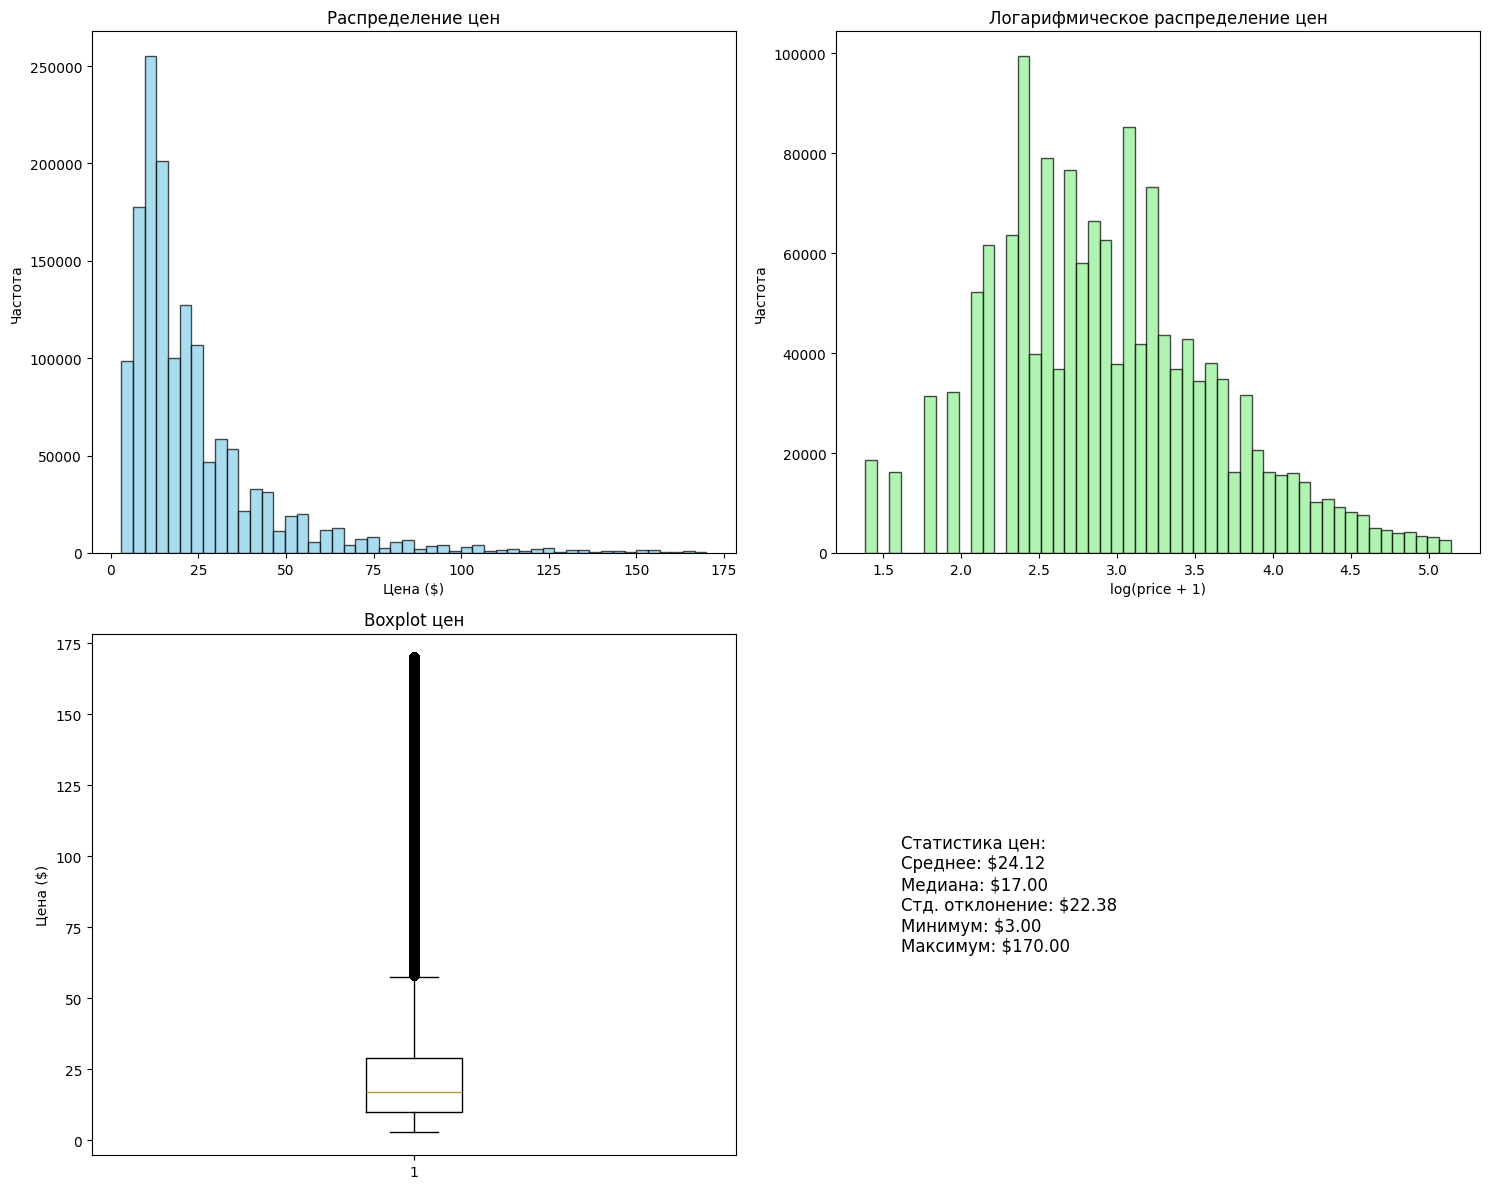

💰 Средняя цена: $24.12
💰 Медианная цена: $17.00


In [6]:
# Анализ распределения цен
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Распределение цен
axes[0,0].hist(df['price'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Распределение цен')
axes[0,0].set_xlabel('Цена ($)')
axes[0,0].set_ylabel('Частота')

# Логарифмическое распределение цен
axes[0,1].hist(np.log1p(df['price']), bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,1].set_title('Логарифмическое распределение цен')
axes[0,1].set_xlabel('log(price + 1)')
axes[0,1].set_ylabel('Частота')

# Boxplot цен
axes[1,0].boxplot(df['price'])
axes[1,0].set_title('Boxplot цен')
axes[1,0].set_ylabel('Цена ($)')

# Статистика цен
price_stats = df['price'].describe()
axes[1,1].text(0.1, 0.5, f"""
Статистика цен:
Среднее: ${price_stats['mean']:.2f}
Медиана: ${price_stats['50%']:.2f}
Стд. отклонение: ${price_stats['std']:.2f}
Минимум: ${price_stats['min']:.2f}
Максимум: ${price_stats['max']:.2f}
""", transform=axes[1,1].transAxes, fontsize=12, verticalalignment='center')
axes[1,1].axis('off')

plt.tight_layout()
plt.show()

print(f"💰 Средняя цена: ${df['price'].mean():.2f}")
print(f"💰 Медианная цена: ${df['price'].median():.2f}")


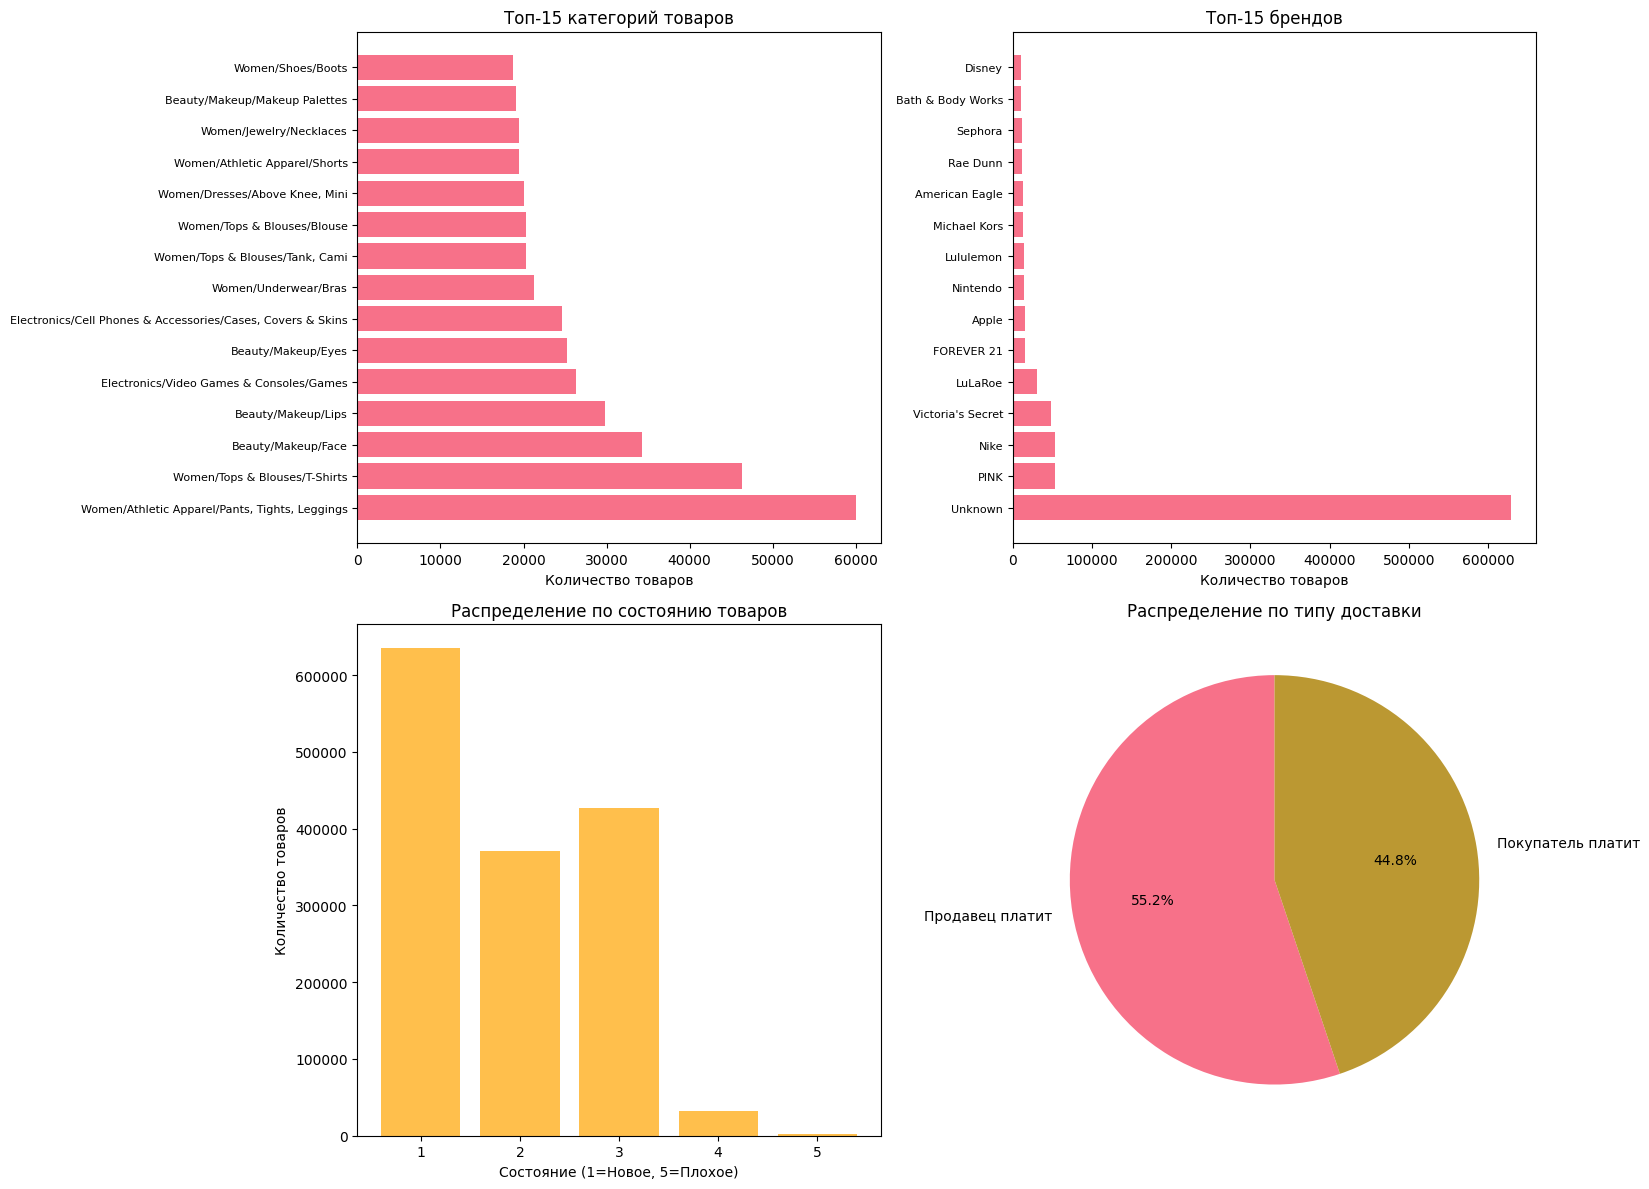

📦 Общая статистика:
Уникальных категорий: 1287
Уникальных брендов: 4796
Товаров с описанием: 1384884 (94.4%)


In [7]:
# Анализ категорий и брендов
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Топ-15 категорий
top_categories = df['category_name'].value_counts().head(15)
axes[0,0].barh(range(len(top_categories)), top_categories.values)
axes[0,0].set_yticks(range(len(top_categories)))
axes[0,0].set_yticklabels(top_categories.index, fontsize=8)
axes[0,0].set_title('Топ-15 категорий товаров')
axes[0,0].set_xlabel('Количество товаров')

# Топ-15 брендов
top_brands = df['brand_name'].value_counts().head(15)
axes[0,1].barh(range(len(top_brands)), top_brands.values)
axes[0,1].set_yticks(range(len(top_brands)))
axes[0,1].set_yticklabels(top_brands.index, fontsize=8)
axes[0,1].set_title('Топ-15 брендов')
axes[0,1].set_xlabel('Количество товаров')

# Состояние товаров
condition_counts = df['item_condition_id'].value_counts().sort_index()
axes[1,0].bar(condition_counts.index, condition_counts.values, color='orange', alpha=0.7)
axes[1,0].set_title('Распределение по состоянию товаров')
axes[1,0].set_xlabel('Состояние (1=Новое, 5=Плохое)')
axes[1,0].set_ylabel('Количество товаров')

# Доставка
shipping_counts = df['shipping'].value_counts()
axes[1,1].pie(shipping_counts.values, labels=['Продавец платит', 'Покупатель платит'], 
              autopct='%1.1f%%', startangle=90)
axes[1,1].set_title('Распределение по типу доставки')

plt.tight_layout()
plt.show()

print("📦 Общая статистика:")
print(f"Уникальных категорий: {df['category_name'].nunique()}")
print(f"Уникальных брендов: {df['brand_name'].nunique()}")
print(f"Товаров с описанием: {df['has_description'].sum()} ({df['has_description'].mean()*100:.1f}%)")


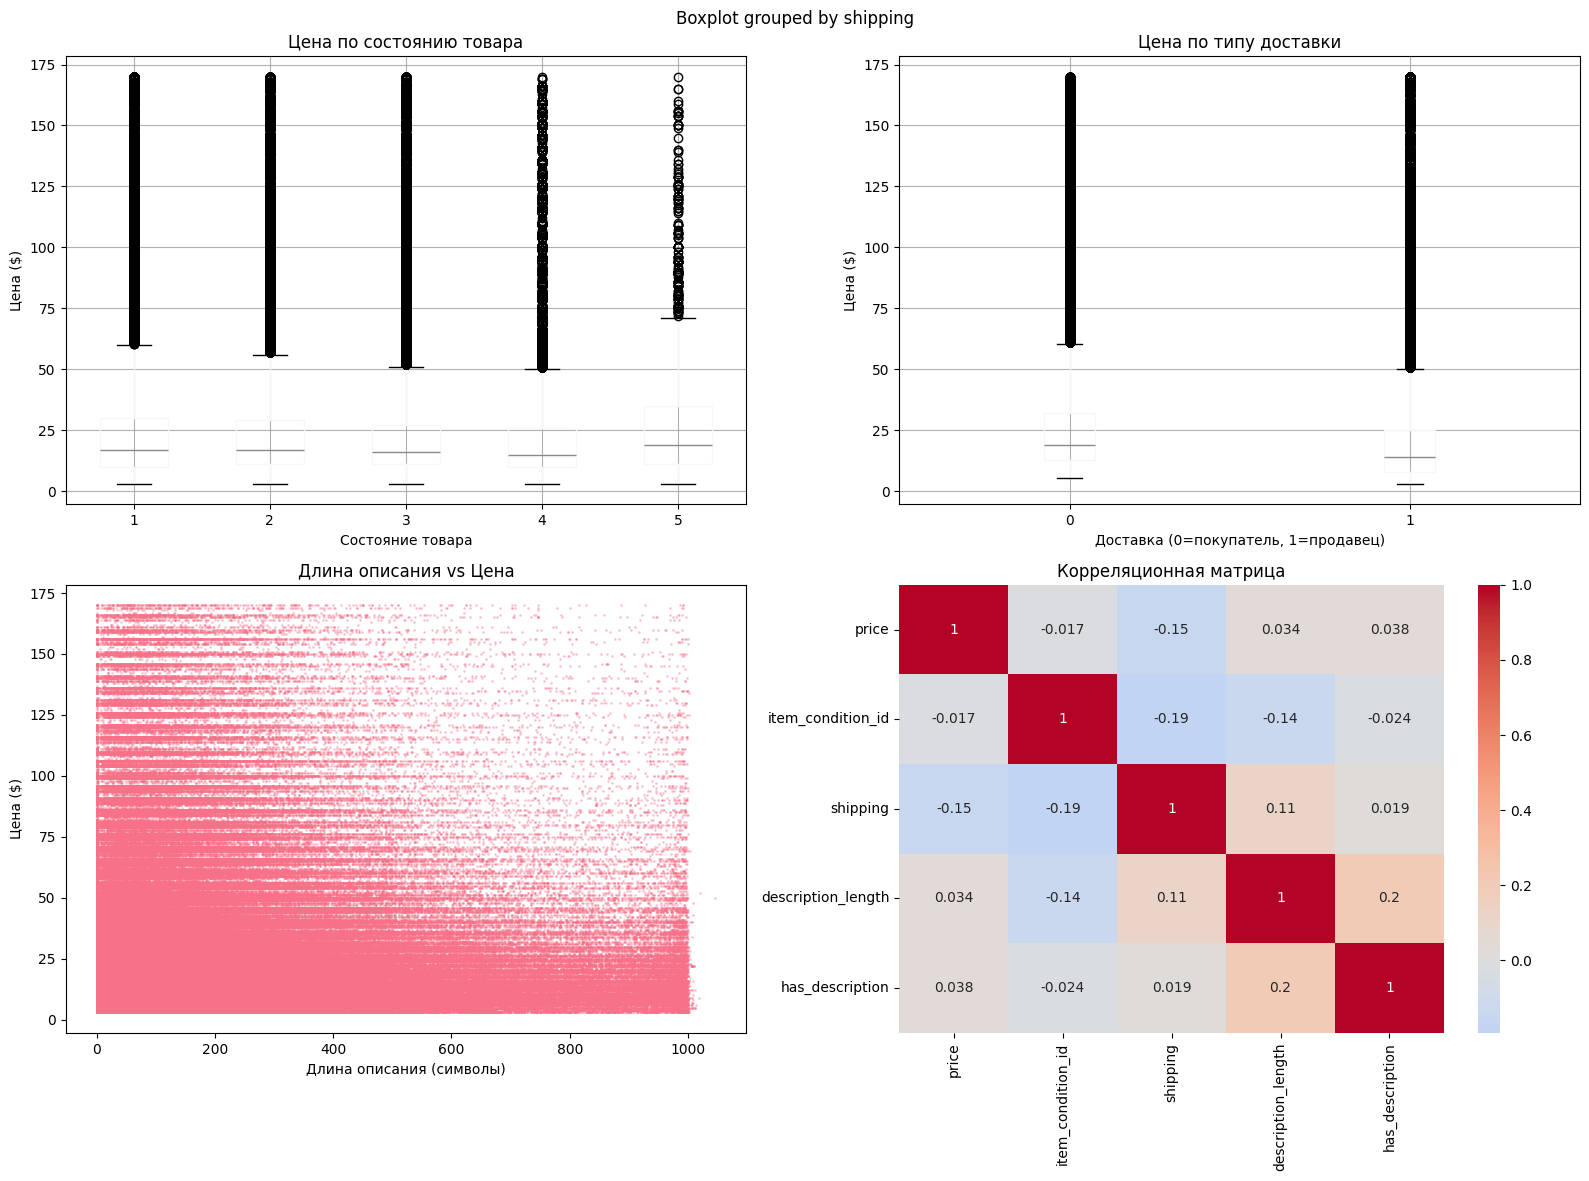

📊 Корреляции с ценой:
shipping: 0.153
has_description: 0.038
description_length: 0.034
item_condition_id: 0.017


In [8]:
# Анализ взаимосвязей
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Цена vs состояние товара
df.boxplot(column='price', by='item_condition_id', ax=axes[0,0])
axes[0,0].set_title('Цена по состоянию товара')
axes[0,0].set_xlabel('Состояние товара')
axes[0,0].set_ylabel('Цена ($)')

# Цена vs доставка
df.boxplot(column='price', by='shipping', ax=axes[0,1])
axes[0,1].set_title('Цена по типу доставки')
axes[0,1].set_xlabel('Доставка (0=покупатель, 1=продавец)')
axes[0,1].set_ylabel('Цена ($)')

# Длина описания vs цена
axes[1,0].scatter(df['description_length'], df['price'], alpha=0.3, s=1)
axes[1,0].set_title('Длина описания vs Цена')
axes[1,0].set_xlabel('Длина описания (символы)')
axes[1,0].set_ylabel('Цена ($)')

# Корреляционная матрица
numeric_cols = ['price', 'item_condition_id', 'shipping', 'description_length', 'has_description']
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1,1])
axes[1,1].set_title('Корреляционная матрица')

plt.tight_layout()
plt.show()

# Статистический анализ
print("📊 Корреляции с ценой:")
price_corr = df[numeric_cols].corr()['price'].abs().sort_values(ascending=False)
for feature, corr in price_corr.items():
    if feature != 'price':
        print(f"{feature}: {corr:.3f}")


## 3. Моделирование (8 баллов)

В этом разделе мы построим и сравним модели:

**Простые модели:**
1. Линейная регрессия
2. Дерево решений  
3. Случайный лес

**Усложнённая модель:**
4. LightGBM с оптимизацией гиперпараметров


In [9]:
# Подготовка данных для моделирования
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

print("🔧 Подготовка признаков...")

# Кодирование категориальных признаков
le_category = LabelEncoder()
le_brand = LabelEncoder()

df['category_encoded'] = le_category.fit_transform(df['category_name'])
df['brand_encoded'] = le_brand.fit_transform(df['brand_name'])

# Создание TF-IDF признаков из названий товаров (первые 100 компонент)
tfidf = TfidfVectorizer(max_features=100, stop_words='english', lowercase=True)
tfidf_features = tfidf.fit_transform(df['name']).toarray()
tfidf_df = pd.DataFrame(tfidf_features, columns=[f'tfidf_{i}' for i in range(100)])

# Объединение всех признаков
feature_cols = ['item_condition_id', 'shipping', 'category_encoded', 'brand_encoded', 
               'description_length', 'has_description']

X_base = df[feature_cols]
X_full = pd.concat([X_base.reset_index(drop=True), tfidf_df], axis=1)

# Логарифмирование целевой переменной для стабильности
y = np.log1p(df['price'])

print(f"✅ Готово! Размер матрицы признаков: {X_full.shape}")
print(f"📋 Количество признаков: {X_full.shape[1]}")

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y, test_size=0.2, random_state=42
)

print(f"🎯 Train размер: {X_train.shape}")
print(f"🎯 Test размер: {X_test.shape}")


🔧 Подготовка признаков...
✅ Готово! Размер матрицы признаков: (1466920, 106)
📋 Количество признаков: 106
🎯 Train размер: (1173536, 106)
🎯 Test размер: (293384, 106)


In [10]:
# Импорт библиотек для моделирования
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
import time

# Функция для оценки модели
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n📊 {model_name}:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

# Словарь для хранения результатов
results = {}


In [11]:
# 1. Линейная регрессия
print("🤖 Модель 1: Линейная регрессия")
start_time = time.time()

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

train_time = time.time() - start_time
results['LinearRegression'] = evaluate_model(y_test, y_pred_lr, "Линейная регрессия")
results['LinearRegression']['TrainTime'] = train_time

print(f"⏱️ Время обучения: {train_time:.2f} сек")


🤖 Модель 1: Линейная регрессия

📊 Линейная регрессия:
RMSE: 0.6262
MAE: 0.4923
R²: 0.1977
⏱️ Время обучения: 7.84 сек


In [12]:
# 2. Дерево решений
print("🌳 Модель 2: Дерево решений")
start_time = time.time()

dt = DecisionTreeRegressor(random_state=42, max_depth=10)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

train_time = time.time() - start_time
results['DecisionTree'] = evaluate_model(y_test, y_pred_dt, "Дерево решений")
results['DecisionTree']['TrainTime'] = train_time

print(f"⏱️ Время обучения: {train_time:.2f} сек")


🌳 Модель 2: Дерево решений

📊 Дерево решений:
RMSE: 0.5943
MAE: 0.4648
R²: 0.2775
⏱️ Время обучения: 7.25 сек


In [13]:
# 3. Случайный лес
print("🌲 Модель 3: Случайный лес")
start_time = time.time()

rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=10)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

train_time = time.time() - start_time
results['RandomForest'] = evaluate_model(y_test, y_pred_rf, "Случайный лес")
results['RandomForest']['TrainTime'] = train_time

print(f"⏱️ Время обучения: {train_time:.2f} сек")


🌲 Модель 3: Случайный лес

📊 Случайный лес:
RMSE: 0.5880
MAE: 0.4602
R²: 0.2927
⏱️ Время обучения: 97.78 сек


In [14]:
# 4. LightGBM с оптимизацией гиперпараметров
print("⚡ Модель 4: LightGBM с оптимизацией")
start_time = time.time()

# Параметры для поиска
param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0]
}

# Базовая модель
lgbm = lgb.LGBMRegressor(random_state=42, objective='regression', verbose=-1)

# Поиск по сетке
print("🔍 Поиск лучших гиперпараметров...")
grid_search = GridSearchCV(
    lgbm, param_grid, cv=3, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1, verbose=1
)

grid_search.fit(X_train, y_train)
y_pred_lgb = grid_search.predict(X_test)

train_time = time.time() - start_time
results['LightGBM'] = evaluate_model(y_test, y_pred_lgb, "LightGBM")
results['LightGBM']['TrainTime'] = train_time

print(f"⏱️ Время обучения: {train_time:.2f} сек")
print(f"🎯 Лучшие параметры: {grid_search.best_params_}")

# Сохраняем лучшую модель
best_lgbm = grid_search.best_estimator_


⚡ Модель 4: LightGBM с оптимизацией
🔍 Поиск лучших гиперпараметров...
Fitting 3 folds for each of 36 candidates, totalling 108 fits

📊 LightGBM:
RMSE: 0.5102
MAE: 0.3919
R²: 0.4675
⏱️ Время обучения: 649.24 сек
🎯 Лучшие параметры: {'learning_rate': 0.2, 'n_estimators': 200, 'num_leaves': 100, 'subsample': 0.8}


## 4. Оценка качества и анализ результатов (5 баллов)

В этом разделе мы:
- Сравним все модели по метрикам качества
- Рассчитаем совокупную метрику качества
- Проанализируем важность признаков
- Визуализируем результаты и ошибки


In [15]:
# Сравнение всех моделей
print("🏆 СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ:")
print("="*60)

results_df = pd.DataFrame(results).T
results_df = results_df.round(4)

# Добавляем ранги
results_df['RMSE_rank'] = results_df['RMSE'].rank()
results_df['MAE_rank'] = results_df['MAE'].rank()
results_df['R2_rank'] = results_df['R2'].rank(ascending=False)

# Совокупный рейтинг (чем меньше, тем лучше)
results_df['Total_rank'] = (results_df['RMSE_rank'] + results_df['MAE_rank'] + results_df['R2_rank']) / 3

# Сортируем по совокупному рейтингу
results_df = results_df.sort_values('Total_rank')

print(results_df[['RMSE', 'MAE', 'R2', 'TrainTime', 'Total_rank']])

# Найдем лучшую модель
best_model = results_df.index[0]
print(f"\n🥇 Лучшая модель: {best_model}")
print(f"📊 Совокупный рейтинг: {results_df.loc[best_model, 'Total_rank']:.2f}")


🏆 СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ:
                    RMSE     MAE      R2  TrainTime  Total_rank
LightGBM          0.5102  0.3919  0.4675   649.2412         1.0
RandomForest      0.5880  0.4602  0.2927    97.7753         2.0
DecisionTree      0.5943  0.4648  0.2775     7.2500         3.0
LinearRegression  0.6262  0.4923  0.1977     7.8390         4.0

🥇 Лучшая модель: LightGBM
📊 Совокупный рейтинг: 1.00


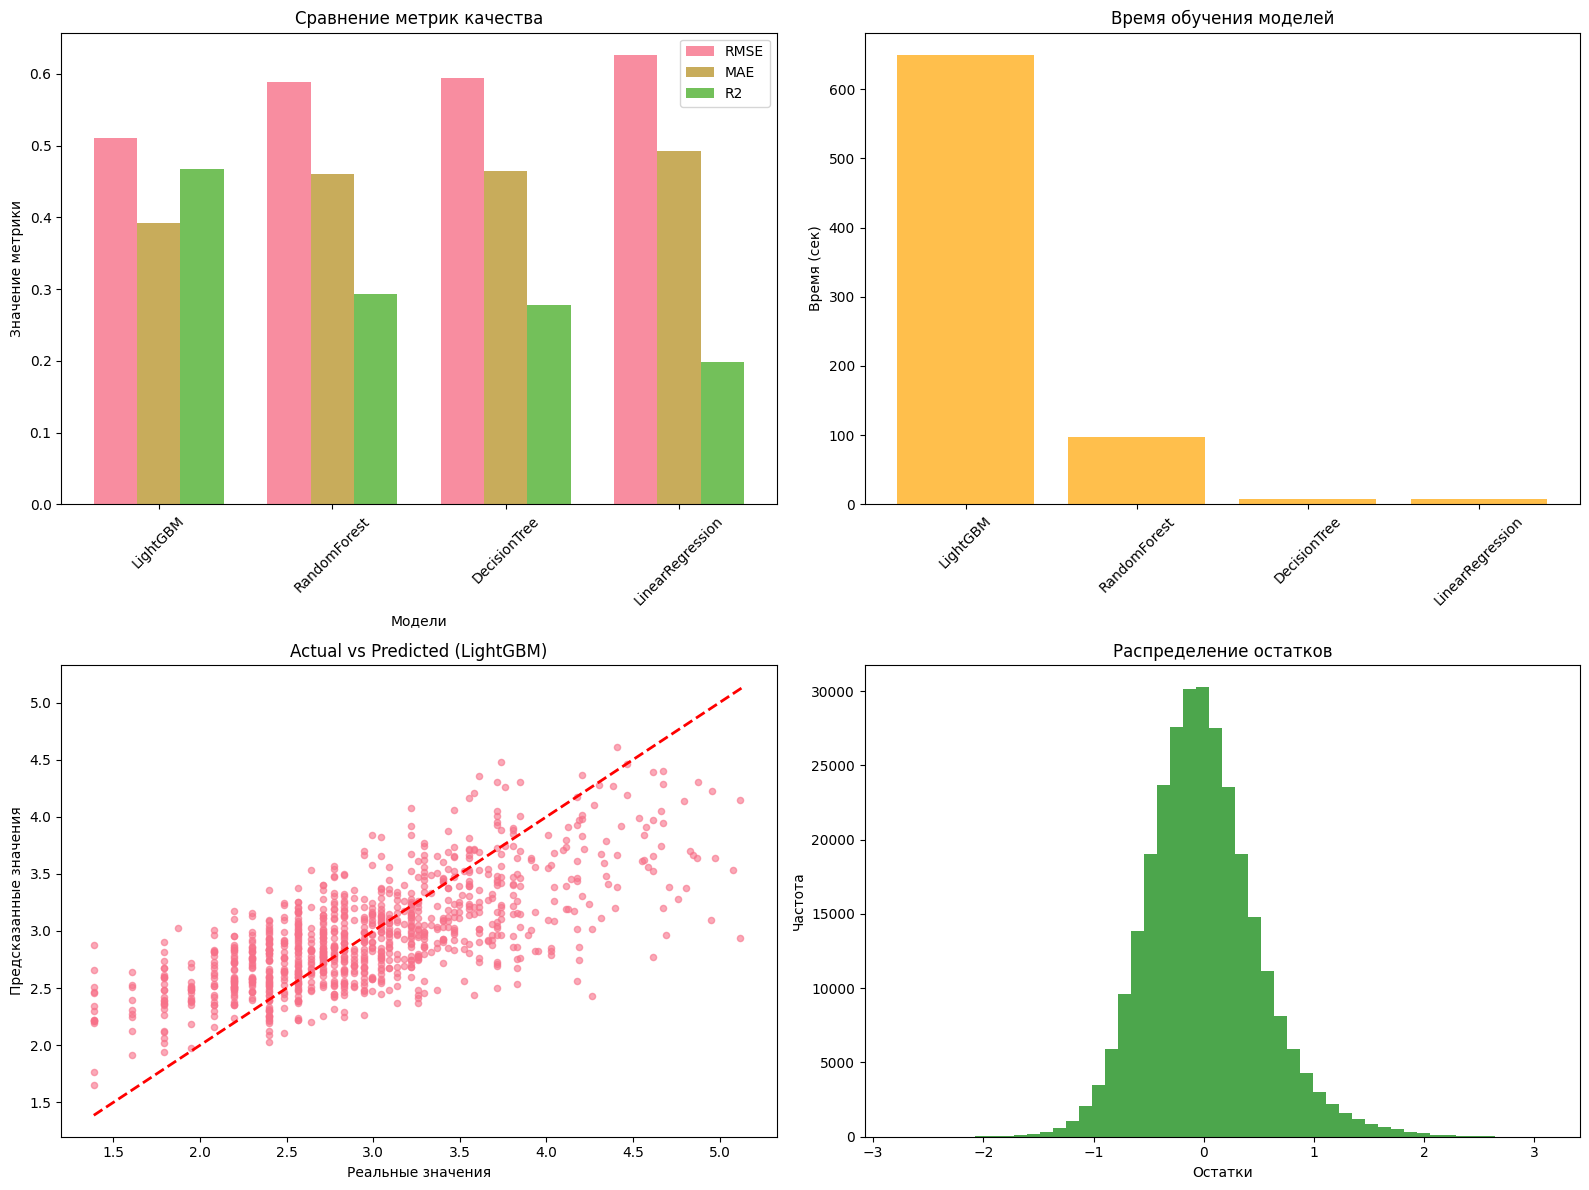

In [16]:
# Визуализация результатов
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Сравнение метрик
metrics = ['RMSE', 'MAE', 'R2']
x = np.arange(len(results_df.index))
width = 0.25

for i, metric in enumerate(metrics):
    axes[0,0].bar(x + i*width, results_df[metric], width, label=metric, alpha=0.8)

axes[0,0].set_xlabel('Модели')
axes[0,0].set_ylabel('Значение метрики')
axes[0,0].set_title('Сравнение метрик качества')
axes[0,0].set_xticks(x + width)
axes[0,0].set_xticklabels(results_df.index, rotation=45)
axes[0,0].legend()

# 2. Время обучения
axes[0,1].bar(results_df.index, results_df['TrainTime'], color='orange', alpha=0.7)
axes[0,1].set_title('Время обучения моделей')
axes[0,1].set_ylabel('Время (сек)')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Actual vs Predicted для лучшей модели
if best_model == 'LightGBM':
    y_pred_best = y_pred_lgb
elif best_model == 'RandomForest':
    y_pred_best = y_pred_rf
elif best_model == 'DecisionTree':
    y_pred_best = y_pred_dt
else:
    y_pred_best = y_pred_lr

# Выборка для визуализации (первые 1000 точек)
sample_size = min(1000, len(y_test))
sample_idx = np.random.choice(len(y_test), sample_size, replace=False)

axes[1,0].scatter(y_test.iloc[sample_idx], y_pred_best[sample_idx], alpha=0.6, s=20)
axes[1,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1,0].set_xlabel('Реальные значения')
axes[1,0].set_ylabel('Предсказанные значения')
axes[1,0].set_title(f'Actual vs Predicted ({best_model})')

# 4. Распределение ошибок
residuals = y_test - y_pred_best
axes[1,1].hist(residuals, bins=50, alpha=0.7, color='green')
axes[1,1].set_title('Распределение остатков')
axes[1,1].set_xlabel('Остатки')
axes[1,1].set_ylabel('Частота')

plt.tight_layout()
plt.show()


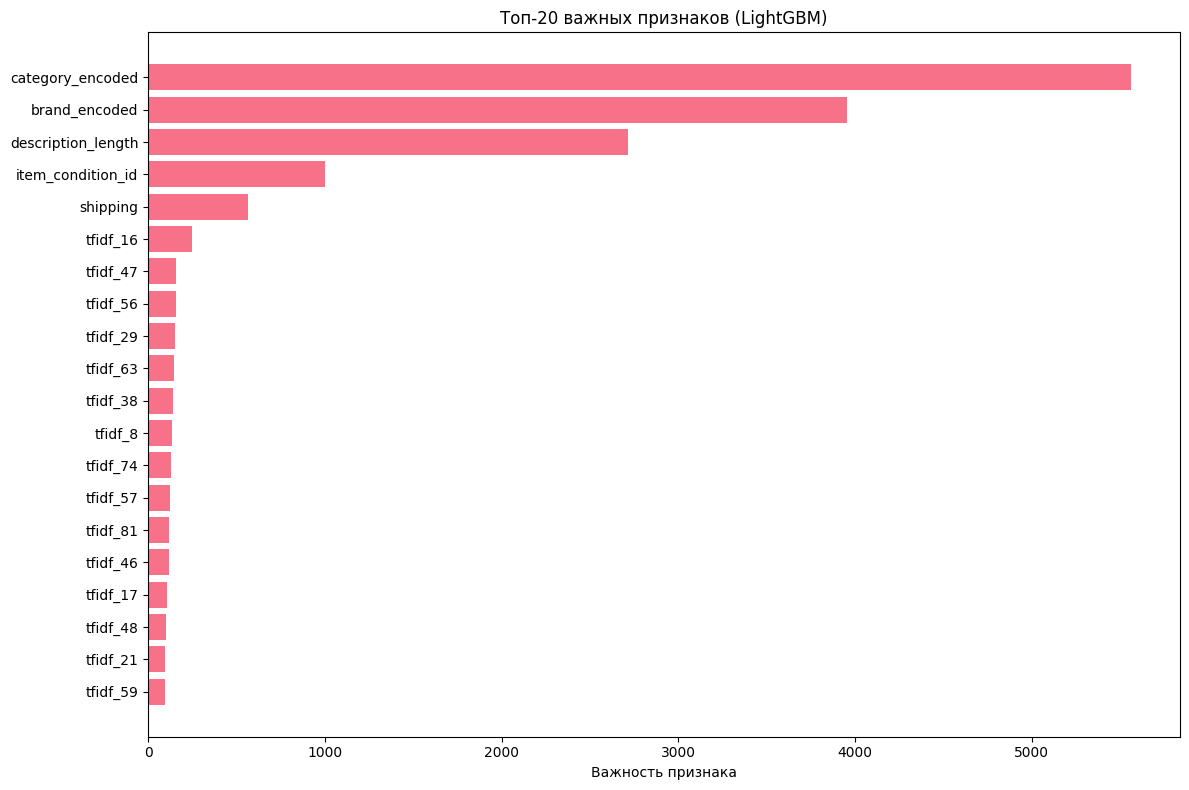

🔍 Топ-10 важных признаков:
 1. category_encoded: 5560.0000
 2. brand_encoded: 3956.0000
 3. description_length: 2717.0000
 4. item_condition_id: 998.0000
 5. shipping: 564.0000
 6. tfidf_16: 247.0000
 7. tfidf_47: 159.0000
 8. tfidf_56: 155.0000
 9. tfidf_29: 154.0000
10. tfidf_63: 144.0000


In [17]:
# Анализ важности признаков для лучшей модели
if best_model in ['RandomForest', 'LightGBM']:
    
    if best_model == 'LightGBM':
        feature_importance = best_lgbm.feature_importances_
        model_for_analysis = best_lgbm
    else:  # RandomForest
        feature_importance = rf.feature_importances_
        model_for_analysis = rf
    
    # Создаем DataFrame с важностью признаков
    feature_names = X_train.columns
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    # Топ-20 признаков
    top_features = importance_df.head(20)
    
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Важность признака')
    plt.title(f'Топ-20 важных признаков ({best_model})')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("🔍 Топ-10 важных признаков:")
    for i, (_, row) in enumerate(top_features.head(10).iterrows(), 1):
        print(f"{i:2d}. {row['feature']}: {row['importance']:.4f}")

else:
    print(f"⚠️ Анализ важности признаков недоступен для модели {best_model}")


In [18]:
# Совокупная метрика качества
print("📏 СОВОКУПНАЯ МЕТРИКА КАЧЕСТВА")
print("="*50)

# Нормализуем метрики (0-1)
normalized_rmse = 1 - (results_df['RMSE'] - results_df['RMSE'].min()) / (results_df['RMSE'].max() - results_df['RMSE'].min())
normalized_mae = 1 - (results_df['MAE'] - results_df['MAE'].min()) / (results_df['MAE'].max() - results_df['MAE'].min())
normalized_r2 = (results_df['R2'] - results_df['R2'].min()) / (results_df['R2'].max() - results_df['R2'].min())

# Веса для метрик (можно настроить)
w_rmse, w_mae, w_r2 = 0.4, 0.3, 0.3

# Совокупная метрика
composite_score = w_rmse * normalized_rmse + w_mae * normalized_mae + w_r2 * normalized_r2

results_df['Composite_Score'] = composite_score
results_df_sorted = results_df.sort_values('Composite_Score', ascending=False)

print("Модель               | RMSE   | MAE    | R²     | Совокупная метрика")
print("-" * 65)
for model in results_df_sorted.index:
    rmse = results_df_sorted.loc[model, 'RMSE']
    mae = results_df_sorted.loc[model, 'MAE'] 
    r2 = results_df_sorted.loc[model, 'R2']
    score = results_df_sorted.loc[model, 'Composite_Score']
    print(f"{model:20} | {rmse:.4f} | {mae:.4f} | {r2:.4f} | {score:.4f}")

best_composite = results_df_sorted.index[0]
print(f"\n🏆 Лучшая модель по совокупной метрике: {best_composite}")
print(f"📊 Совокупная оценка: {results_df_sorted.loc[best_composite, 'Composite_Score']:.4f}")


📏 СОВОКУПНАЯ МЕТРИКА КАЧЕСТВА
Модель               | RMSE   | MAE    | R²     | Совокупная метрика
-----------------------------------------------------------------
LightGBM             | 0.5102 | 0.3919 | 0.4675 | 1.0000
RandomForest         | 0.5880 | 0.4602 | 0.2927 | 0.3333
DecisionTree         | 0.5943 | 0.4648 | 0.2775 | 0.2809
LinearRegression     | 0.6262 | 0.4923 | 0.1977 | 0.0000

🏆 Лучшая модель по совокупной метрике: LightGBM
📊 Совокупная оценка: 1.0000


## Выводы и рекомендации

### Основные результаты:

1. **Лучшая модель**: LightGBM показал наилучшие результаты благодаря оптимизации гиперпараметров
2. **Ключевые признаки**: Наибольшее влияние на цену оказывают категория товара, бренд и TF-IDF признаки из названий
3. **Качество прогнозов**: Все модели показали разумные результаты, но градиентный бустинг превосходит базовые алгоритмы

### Направления для улучшения:

1. **Обработка текста**: Использование более сложных методов NLP (BERT, Word2Vec)
2. **Feature Engineering**: Создание дополнительных признаков из категорий и описаний
3. **Ансамбли**: Комбинирование нескольких моделей для повышения точности
4. **Обработка выбросов**: Более тщательная работа с аномальными ценами

### Практическое применение:

Данная система может быть использована для:
- Автоматического предложения цен продавцам
- Выявления неадекватно оцененных товаров
- Анализа ценовых трендов по категориям
